In [1]:
import numpy as np
import pandas as pd

# Step 1: Building List

## Collecting instances from 311 calls, crimes, and blight violations

Data already cleaned by [this notebook](./Cleaning_data.ipynb)
The collection of data was saved at __../data/events.csv__

In [2]:
data_events = pd.read_csv('../data/events.csv')

In [3]:
data_events.sort_values(by='addr',inplace=True)

In [4]:
data_events.head(10)

,event_id,lon,lat,addr,type
2778,2778,-83.041618,42.408738,5949 casmere st,1
919,919,-83.175329,42.358054,8641 littlefield,1
12722,12722,-83.137666,42.338734,wagner,1
371125,371125,-83.216326,42.369786,0 10th,3
409945,409945,-83.216326,42.369786,0 10th,3
370505,370505,-83.216326,42.369786,0 10th,3
184559,184559,-83.216326,42.369786,0 10th,3
370506,370506,-83.216326,42.369786,0 10th,3
375767,375767,-83.216326,42.369786,0 10th,3
375800,375800,-83.216326,42.369786,0 10th,3


In [5]:
events_grouped = data_events.groupby(by=['addr'], axis=0)

In [41]:
events_grouped_list = {'addr': [], 'lon': [], 'lat': [], 'event_id_list': []}

unknown_address = []

def similar_vals(lst, epsilon=1.0e-5):
    '''determine if a input list contains almost identical values. If it does, return 
    median value. Otherwise return -9999.
    
    This function is for double checking if coordinates grouped by same address are
    actually the same.
    '''
    if len(lst) == 1:
        return lst[0]
    
    avg_val = np.median(lst)
    notSimilar = False
    for val in lst:
        if abs(val-avg_val) > epsilon:
            notSimilar=True
            break
    if notSimilar:
        return -9999
    else:
        return avg_val

In [42]:
epsilon = 1.0e-5 # match ~1/40 average length or 1/20 average width

# loop through each events grouped by address, check if each group contain similar address,
# If they do, then assume these entries share a same building.
# For the same address containing different coordiates, process them later (unknown address)
for a_group in events_grouped:
    address, entry = a_group
    event_id_list = entry['event_id'].values.tolist()
    lon = entry['lon'].drop_duplicates().values.tolist()
    lat = entry['lat'].drop_duplicates().values.tolist()
    
    if len(lon) == 1:
        lon = lon[0] 
    else:
        effect_lon = similar_vals(lon,epsilon)
        if effect_lon < -1000:
            unknown_address.append(entry)
            continue
        lon = effect_lon
        
    if (len(lat) == 1):
        lat = lat[0]
    else:
        effect_lat = similar_vals(lat,epsilon)
        if effect_lat < -1000:
            unknown_address.append(entry)
            continue
        lat = effect_lat
        
        
    if len(events_grouped_list['addr']) != 0:
        # check if previous address is actually the same
        prev_lon = events_grouped_list['lon'][-1]
        prev_lat = events_grouped_list['lat'][-1]
        if (abs(lon-prev_lon) < epsilon) and (abs(lat-prev_lat) < epsilon):
            events_grouped_list['event_id_list'][-1] = events_grouped_list['event_id_list'][-1] \
                                                            + event_id_list
        else:
            events_grouped_list['addr'].append(address)
            events_grouped_list['lon'].append(lon)
            events_grouped_list['lat'].append(lat)
            events_grouped_list['event_id_list'].append(event_id_list)
    else:
        events_grouped_list['addr'].append(address)
        events_grouped_list['lon'].append(lon)
        events_grouped_list['lat'].append(lat)
        events_grouped_list['event_id_list'].append(event_id_list)

    
buildings = pd.DataFrame(events_grouped_list)

In [43]:
len(unknown_address)   # unclassified entries

22448

In [44]:
buildings.shape   # buildings identified by address then coordinates

(157193, 4)

In [45]:
unknown_address = pd.concat(unknown_address)
unknown_address.shape

(98117, 5)

In [46]:
unknown_address.tail(5) 
# For these address, sometimes only a street name was specified

,event_id,lon,lat,addr,type
2882,2882,-83.106815,42.419343,woodward,1
14006,14006,-83.084943,42.387579,woodward,1
11127,11127,-83.106815,42.419343,woodward,1
7564,7564,-83.051336,42.429773,wyoming,1
10278,10278,-83.159021,42.387087,wyoming,1


In [47]:
# Following procedure is followed to construct buildings_part2 from unknown_address:
# Events are looped,
# For each event:
#     If event not in previous building rectangular area:
#         define new building at the event coordinate, with length and width taken from step0
#
# convert the events into dataframe

In [48]:
events_part2 = {'addr': [], 'lon': [], 'lat': [], 'event_id_list': []}
prev_llcrnrlon = 0
prev_llcrnrlat = 0
prev_urcrnrlon = 0
prev_urcrnrlat = 0
length = 4.11e-4 # longitude
width = 2.04e-4 # latitude
for i, entry in unknown_address.iterrows():
    lon = entry['lon']
    lat = entry['lat']
    if (lon<prev_llcrnrlon) or (lon>prev_urcrnrlon) or (lat<prev_llcrnrlat) or (lat>prev_urcrnrlat):
        events_part2['addr'].append(entry['addr'])
        events_part2['lon'].append(entry['lon'])
        events_part2['lat'].append(entry['lat'])
        events_part2['event_id_list'].append([entry['event_id'],])
        
        prev_llcrnrlon = lon - length/2
        prev_llcrnrlat = lat - length/2
        prev_urcrnrlon = lon + length/2
        prev_urcrnrlat = lat + length/2
    else:
        events_part2['event_id_list'][-1] = events_part2['event_id_list'][-1] + [entry['event_id'],]

In [49]:
events_part2_df = pd.DataFrame(events_part2)

In [50]:
events_part2_df.shape

(66933, 4)

In [51]:
events_part2_df.head(5)

,addr,event_id_list,lat,lon
0,00 abington/schoolcraft,[23256],42.3869,-83.2119
1,00 abington/schoolcraft,[38495],42.3866,-83.2117
2,00 across from 2213 lillibridge,[31096],42.3698,-82.9754
3,00 across from 2213 lillibridge,[26074],42.3699,-82.9757
4,00 across from 2938 mclean,"[46059, 77435]",42.4090,-83.0651


In [52]:
# For buildings classified in the initial step, there is another problem:
# Different address may actually locate on the same building. They may just be
# apartment complex or of other reasons.
# To take care of this possibility, we can cluster them further:
#
# For building in buildings sorted by 'lat':
#    if building.lat same as prev_lat & building.lon same as prev_lon:
#        prev_event_list.append(event_id_list)
buildings.sort_values(by='lon',inplace=True)

buildings_concise = {'addr': [], 'lon': [], 'lat': [], 'event_id_list': []}

prev_llcrnrlon = 0
prev_llcrnrlat = 0
prev_urcrnrlon = 0
prev_urcrnrlat = 0
length = 4.11e-4 # longitude
width = 2.04e-4 # latitude
for i, entry in buildings.iterrows():
    lon = entry['lon']
    lat = entry['lat']
    if (lon<prev_llcrnrlon) or (lon>prev_urcrnrlon) or (lat<prev_llcrnrlat) or (lat>prev_urcrnrlat):
        buildings_concise['addr'].append(entry['addr'])
        buildings_concise['lon'].append(entry['lon'])
        buildings_concise['lat'].append(entry['lat'])
        # below line is different from the loop for events_part2
        buildings_concise['event_id_list'].append(entry['event_id_list']) 
        
        prev_llcrnrlon = lon - length/2
        prev_llcrnrlat = lat - length/2
        prev_urcrnrlon = lon + length/2
        prev_urcrnrlat = lat + length/2
    else:
        buildings_concise['event_id_list'][-1] = buildings_concise['event_id_list'][-1]\
                                                + entry['event_id_list']

In [53]:
len(buildings_concise['addr'])  # shorter than before

133365

In [55]:
buildings_part1 = pd.DataFrame(buildings_concise)
buildings_part1.shape

(133365, 4)

In [54]:
events_part2_df.shape

(66933, 4)

In [57]:
buildings_all = pd.concat([buildings_part1, events_part2_df])

### Get rid of void coordinates

In [58]:
buildings_all = buildings_all[(buildings_all['lat']>42) & (buildings_all['lat']<42.5) & (buildings_all['lon']>-84) & (buildings_all['lon']<-82)]

In [59]:
buildings_all.shape

(200298, 4)

## Recap of [step 0](./Building_size_estimation.ipynb)

## Adopting building coordinates
It turns out that there is a slight mismatch between real world building coordinates w.r.t given data. So that only average building dimension info is reserved from the building info we got from online open data at data.detroitmi.gov.

In [172]:
data_dir = '../data/'

In [173]:
buildings_step_0 = pd.read_csv(data_dir+'buildings_step_0.csv')
permits = pd.read_csv(data_dir+'permits.csv')

In [174]:
permits = permits[['PARCEL_NO', 'BLD_PERMIT_TYPE', 'addr', 'lon', 'lat']]

In [175]:
permits['BLD_PERMIT_TYPE'].unique()

array(['Dismantle', 'DISM'], dtype=object)

### For example: the very first entry of permit has coordinate:

In [179]:
lon01 = permits.loc[1200,'lon']
lat01 = permits.loc[1200,'lat']
print(lon01,lat01)

-83.107940092 42.382456019


### In real world data, this corresponds to:

In [177]:
c = buildings_step_0['addr'].apply(lambda x: x == permits.loc[0,'addr'])

In [181]:
buildings_step_0[c][['lon','lat']]

,lon,lat
261994,-82.947708,42.393997


The coordinate of this building from data.detroitmi.gov is different from data given in our course material.

### Only building dimension info is adopted for our analysis.

In [16]:
length = 0.000411
width = 0.000204  # These results come from step 0.

In [60]:
buildings_all['llcrnrlon'] = buildings_all['lon'] - length/2
buildings_all['llcrnrlat'] = buildings_all['lat'] - width/2
buildings_all['urcrnrlon'] = buildings_all['lon'] + length/2
buildings_all['urcrnrlat'] = buildings_all['lat'] + width/2

buildings_all['building_id'] = np.arange(0,buildings_all.shape[0])

In [61]:
buildings_all.head()

,addr,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
0,13500 norborne,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0
1,26200 mich ave inkster mi 48141,[116216],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1
2,25800 elsinore,[70770],42.3986,-83.2966,-83.296806,42.398498,-83.296394,42.398702,2
3,00000 mile/ beach daily,[20244],42.3993,-83.2959,-83.296106,42.399198,-83.295694,42.399402,3
4,00 fellrath apartments,[109241],42.2654,-83.2931,-83.293306,42.265298,-83.292894,42.265502,4


In [62]:
buildings_all.to_csv('../data/buildings.csv', index=False)

### Visualization

In [63]:
from bbox import draw_screen_bbox
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
buildings = pd.read_csv('../data/buildings.csv')
bboxes = buildings.loc[:,['llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat']]
bboxes = bboxes.as_matrix()

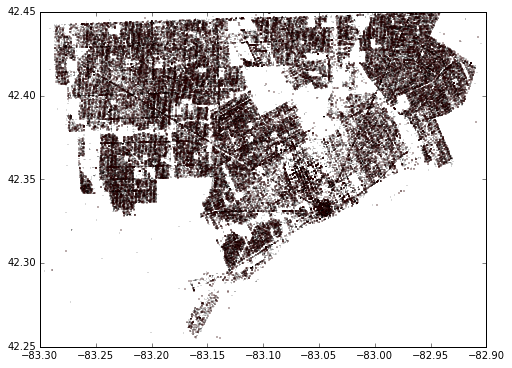

In [65]:
fig = plt.figure(figsize=(8,6), dpi=2000)
for box in bboxes:     
    draw_screen_bbox(box, fig)
    
plt.xlim(-83.3,-82.9)
plt.ylim(42.25,42.45)
plt.savefig('../data/buildings_distribution.png')
plt.show()